In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import quantstats as qs

In [118]:
perp_df = pd.read_csv('BINANCE_BTCUSDT.P, 1D_dbb04.csv')
perp_df.set_index('time', inplace=True)
perp_df = perp_df.loc[:'2023-06-01T20:00:00-04:00']
perp_df.index = [time.replace('T20:00:00-04:00', '') for time in perp_df.index]
perp_df.index = pd.to_datetime(perp_df.index)
perp_df.index = [time.strftime('%Y-%m-%d') for time in perp_df.index]

df = yf.Ticker("BTC-USD").history(start="2019-09-07", end="2023-06-02")
df.index = [time.strftime('%Y-%m-%d') for time in df.index]

In [119]:
perp_close = perp_df['close']
perp_close = perp_close.rename('perp_close')

BTC_close = df['Close']
BTC_close = BTC_close.rename('BTC_close')

df = pd.concat([BTC_close, perp_close], axis=1)
df['funding_rate'] = df['BTC_close']/df['perp_close'] -1
df['Funding Rate % - 1'] = df['funding_rate'].pct_change()

df.index = pd.to_datetime(df.index)

In [120]:
backtest = df.iloc[:len(df)//2]
forward_test = df.iloc[len(df)//2:]

In [121]:
backtest

,BTC_close,perp_close,funding_rate,Funding Rate % - 1
2019-09-07,10517.254883,10391.63,0.012089,NaN
2019-09-08,10441.276367,10307.00,0.013028,0.077644
2019-09-09,10334.974609,10102.02,0.023060,0.770092
2019-09-10,10115.975586,10159.55,-0.004289,-1.185992
2019-09-11,10178.372070,10415.13,-0.022732,4.300084
...,...,...,...,...
2021-07-15,31780.730469,31382.95,0.012675,-0.577465
2021-07-16,31421.539062,31496.65,-0.002385,-1.188143
2021-07-17,31533.068359,31767.00,-0.007364,2.087976
2021-07-18,31796.810547,30823.62,0.031573,-5.287474


In [122]:
def funding_rate_strategy(df):
    
    initial_capital = 100000
    lot = 0
    last_realized_capital = initial_capital
    unrealized_pnl = 0
    equity =  last_realized_capital + unrealized_pnl
    open_direction = None
    open_price = 0
    equity_list = []
    
    for date, row in df.iterrows():
        
        unrealized_pnl = (row['BTC_close']-open_price)*lot
        equity =  last_realized_capital + unrealized_pnl
        
        if row['Funding Rate % - 1'] > 0 and lot == 0:
            open_price = row['BTC_close']
            lot = -round(last_realized_capital/row['BTC_close'], 3)
        
        elif row['Funding Rate % - 1'] < 0 and lot == 0:
            open_price = row['BTC_close']
            lot = round(last_realized_capital/row['BTC_close'], 3)
        
        elif row['Funding Rate % - 1'] > 0 and lot > 0:
            
            close_price = row['BTC_close']
            realized_pnl = unrealized_pnl
            last_realized_capital += realized_pnl
            lot = 0
            
            open_price = row['BTC_close']
            lot = round(last_realized_capital/row['BTC_close'], 3)
        
        elif row['Funding Rate % - 1'] > 0 and lot > 0:
            
            close_price = row['BTC_close']
            realized_pnl = unrealized_pnl
            last_realized_capital += realized_pnl
            lot = 0
            
            open_price = row['BTC_close']
            lot = -round(last_realized_capital/row['BTC_close'], 3)
        
        equity_list.append(equity)
    
    return equity_list

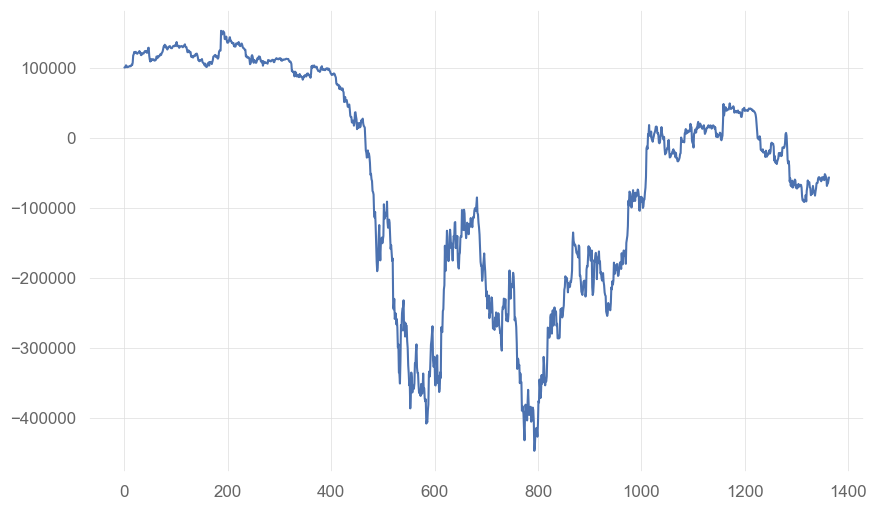

In [123]:
plt.plot(funding_rate_strategy(df))